# Synthetic PSD data and Finding an optimal cut.

Pulse shape discrimination is deceptively complicated.
Sure, the pulse shapes look different, and you can pretty easily come up with a metric to quantitatively describe this difference (like $Q_{fast}/Q_{total}$).
Then you can make a simple cut, maybe with some crude optimisation of the cut location.
Simple.
But, if you want to do any of these things optimally, it gets complicated.

At its heart, it's a classification problem, and by using $Q_{fast}/Q_{total}$ we're doing some feature engineering (the number of features goes from the initial number of samples in the waveform to a ratio of two features, more or less). This is crude. Maybe a better approach would be to use PCA to select some important features, then use a classifier like a support vector classifier to discriminate between neutrons and gammas. Let's make that the aim, and see if it does any better than the usual approach.

Of course, first we need to have a labelled set of data. This means we need to be able to distinguish noise (easy enough to measure), neutrons, and gammas. For neutrons, we just so happen to be planning an experiment where we'll be tagging neutron events in a detector. So that's good. And it should be easy enough to measure gamma rays. We need to generate enough statistics over a wide enough energy range to describe the detector response space. It isn't clear that that's do-able for neutrons, but for gammas it should be easy enough.

Things to do:

- Get a sample of labelled raw detector pulses, taken over an energy range that we expect to span our detector response space. We may need to do some processing to align the pulses, etc. but the features will be the samples from the digitizer. I don't have these so maybe synthesise some data.

- Do some dimension reduction (PCA?) to engineer maximally informative features.

- Train a classifier on the labelled samples with the engineered features, doing proper cross-validation.

- Take some real data in a mixed field. Note that the basic detector conditions should be the same (same HV, thresholds, electronics, impedances, and a similar enough event rate). Use the classifier to sort neutrons and gammas. 

Other thoughts:

- More validation: it should be possible to do regular calibrations using a gamma source. If SABRE wants to include something like this in the detector, then they could use a gamma source (or several) and an AmC source (no gamma rays).

- This would be significantly easier to do in a liquid scintillator, as you can spike it (for instance, a parent $\alpha$-decays to a metastable state then the metastable daughter gives off a low energy gamma a few ms later. Self-labelling data.

- This seems to have been looked at back in 2012: http://ieeexplore.ieee.org/abstract/document/6551092/ (paywalled). Also this one: http://iopscience.iop.org/article/10.1088/1748-0221/8/05/P05023/meta and this one: http://www.sciencedirect.com/science/article/pii/S0168900214015551?np=y&npKey=ea5f167b412e73317e14d2199379b19c9ec135c609f8d2c54221891a90c108cb.

- A (naive?) criticism of a ML approach is that we do actually know quite a bit about the physics of scintillators, so it should be possible to make a model of the waveforms and do fits on a case-by-case basis. Then you can do classification on the fit parameters. The problem here is that waveforms rarely look as nice as you'd expect; and the causes of the not-niceness are often experimentally inacessable (it might be an impedance mismatch from a slightly corroded connector, for instance). This argues for *in situ* measurements that are agnostic to any model (or at least are flexible enough to accomodate reasonable deviations from the model.

There are a few things I should play with before I can feel ready to tackle the PSD problem. Let's start with the feature engineering.


## Feature Engineering

[This blog](http://sebastianraschka.com/Articles/2014_pca_step_by_step.html) has a really good discussion of the difference between PCA and Mutiple Discriminant Analysis (MDA).

- PCA: project the entire set of samples onto a new feature subspace, where the basis vectors of the space are chosen so that they maximise the variance of the data (in decreasing order).

- MDA: project the entire set of labelled samples onto a new feature subspace, where the basis vectors of the space are chosen so that they maximise the separation between the classes.

I think it's clear that MDA is by design much better. I think this is AKA a Fisher discriminant. This makes sense: the context in which I read about Fisher discriminants was finding a cut that isn't a straight line. It works by projecting the data onto another space where the cut *is* a straight line.

So I'll use a discriminant (known as a Multiple Discriminant Analysis, Linear/Quadradic Discriminant Analysis, and Fisher Discriminant Analysis).

Let's first look at sklearn's tutorial, which uses the iris dataset:

In [2]:
import numpy as np
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import itertools
from scipy import signal
%matplotlib inline

explained variance ratio (first two components): [ 0.92461621  0.05301557]


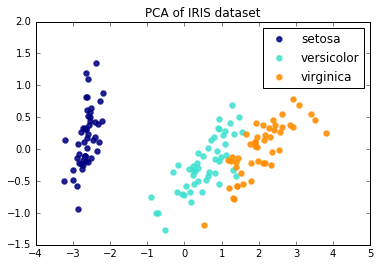

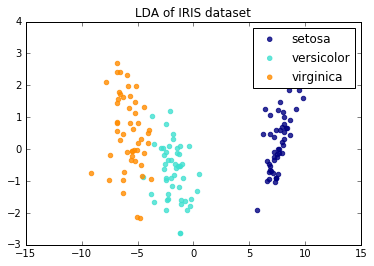

In [3]:
iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')

plt.show()

OK, that's a bit too easy.
Let's see what happens if I try and give it something more realistic.
I'll synthesise some waveform pulses for neutrons and gammas, using the shape of the waveform as:

$y\left(t\right) = \frac{\tau_{r} + \tau_{d}}{\tau_{d}^{2}}\left(1 - e^{-\frac{t}{\tau_{r}}}\right)\left(A_{f}e^{-\frac{t}{\tau_{f}}} + A_{s}e^{-\frac{t}{\tau_{s}}}\right)$

Where $\tau_{d} = \tau_{f} + \tau_{s}$, for the fast and slow decay components.

Gammas: 0.9999999999999941, Neutrons: 1.0000000000000153


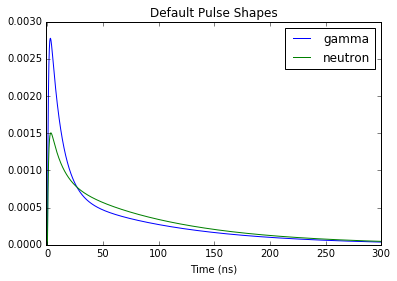

In [9]:
t_r = 1.
t_f = 10.
t_s = 100.
A_f = 0.8
A_s = 0.2
xvals = np.linspace(0, 1000, 10001)
const = ((t_r + t_f + t_s)/((t_f + t_s)**2))
yvals_gamma = (1-np.exp(-xvals/t_r))*(A_f*np.exp(-xvals/t_f) + A_s*np.exp(-xvals/t_s))
yvals_gamma /= sum(yvals_gamma)
A_f = 0.5
A_s = 0.5
yvals_neutron = (1-np.exp(-xvals/t_r))*(A_f*np.exp(-xvals/t_f) + A_s*np.exp(-xvals/t_s))
yvals_neutron /= sum(yvals_neutron)
plt.plot(xvals, yvals_gamma, label='gamma')
plt.plot(xvals, yvals_neutron, label='neutron')
#plt.yscale('log')
plt.legend()
plt.xlim(-1, 300)
print("Gammas: {0}, Neutrons: {1}".format(sum(yvals_gamma), sum(yvals_neutron)))
plt.xlabel('Time (ns)')
plt.title('Default Pulse Shapes')
plt.savefig('/home/lbignell/Lectures/numericalPSD_PulseShapes.png', dpi=200)

Those look OK.
Now let's add some noise and smear the timing with a Gaussian:

Gammas: 0.4841934452059047, Neutrons: 0.49050140828566563
12000


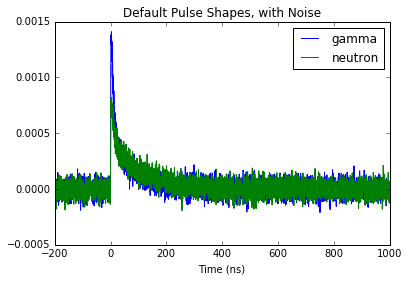

In [8]:
Wfm_gamma = np.random.normal(0, 0.0002, 12000)
Wfm_gamma[1999:] += yvals_gamma
Wfm_neutron = np.random.normal(0,0.0002, 12000)
Wfm_neutron[1999:] += yvals_neutron
conv_sigma = 2
conv_mean = 0
conv_kernel = (1./np.sqrt(2*np.pi*conv_sigma**2))*np.exp(-0.5*(((np.linspace(-10,10,11)-conv_mean)/conv_sigma)**2))
conv_mode = 'same'
Wfm_gamma = np.convolve(Wfm_gamma, conv_kernel, mode = conv_mode)
Wfm_neutron = np.convolve(Wfm_neutron, conv_kernel, mode = conv_mode)
timevals = np.linspace(-200, 1000, len(Wfm_neutron))
plt.plot(timevals, Wfm_gamma, label='gamma')
plt.plot(timevals, Wfm_neutron, label='neutron')
plt.legend()
print("Gammas: {0}, Neutrons: {1}".format(sum(Wfm_gamma), sum(Wfm_neutron)))
print(len(Wfm_gamma))
plt.xlabel('Time (ns)')
plt.title('Default Pulse Shapes, with Noise')
plt.savefig('/home/lbignell/Lectures/numericalPSD_PulseShapes_noisy.png', dpi=200)

Great! So now I want to synthesise some labelled waveform data.
I'll have three groups:

- Neutrons: they all have the same shape and noise level, but the underlying signal is multiplied by a factor which is sampled from an exponential distribution.

- Gammas: They also all have the same shape and noise level, but the underlying signal is multiplied by a factor which is sampled from an exponential distribution.

- Noise: Synthesise some waveforms with just the constant noise level.

Then I'll do a linear discriminant analysis, compare it with the traditional $Q_{fast}/Q_{total}$ analysis, and go from there...

In [11]:
def get_wfm(particle_type, scalefactor=1):
    """
    Return the unmodified waveform for a particle interaction ('gamma' or 'neutron').
    """
    #Scintillator parameters
    t_r = 1.
    t_f = 10.
    t_s = 100.
    if 'gamma' in particle_type.lower():
        A_f = 0.8
        A_s = 0.2
    elif 'neutron' in particle_type.lower():
        A_f = 0.5
        A_s = 0.5
    else:
        print("Error: Unknown particle type {0}".format(particle_type))

    xvals = np.linspace(0, 1000, 10001)
    yvals = (1-np.exp(-xvals/t_r))*(A_f*np.exp(-xvals/t_f) + A_s*np.exp(-xvals/t_s))
    return np.random.exponential(scale=scalefactor)*yvals/np.abs(sum(yvals))

#Set up convolution parameters
conv_sigma = 2
conv_mean = 0
conv_kernel = (1./np.sqrt(2*np.pi*conv_sigma**2))*np.exp(-0.5*(((np.linspace(-10,10,11)-conv_mean)/conv_sigma)**2))
conv_mode = 'same'

noise_lvl = 0.0003

Ngammas = 1000 #12000 x 1000 array ~ 96 MB
Gammas = np.random.normal(0, noise_lvl, (12000, Ngammas))
for i in range(Ngammas):
    Gammas[1999:, i] += get_wfm('gamma')
    Gammas[:, i] = np.convolve(Gammas[:, i], conv_kernel, mode = conv_mode)
    
Nneutrons = 1000 #12000 x 1000 array ~ 96 MB
Neutrons = np.random.normal(0, noise_lvl, (12000, Nneutrons))
for i in range(Nneutrons):
    Neutrons[1999:, i] += get_wfm('neutrons')
    Neutrons[:, i] = np.convolve(Neutrons[:, i], conv_kernel, mode = conv_mode)
    
Nnoise = 1000 #12000 x 1000 array ~ 96 MB
Noise = np.random.normal(0, noise_lvl, (12000, Nnoise))
for i in range(Nnoise):
    Noise[:, i] = np.convolve(Noise[:, i], conv_kernel, mode = conv_mode)


Crude FOM: -37.96550177832074
Half-way cut: 0.2933211161161766


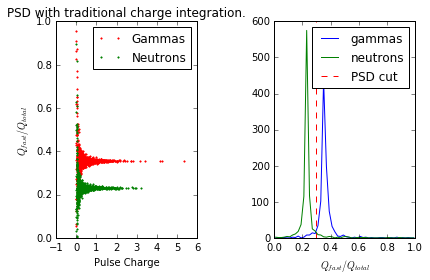

In [14]:
#Lets define the fast integration region as 190:220, and the total integration region as 190:.
Qf_gamma = np.sum(Gammas[1900:2200, :], axis=0)
Qt_gamma = np.sum(Gammas[1900:, :], axis=0)

Qf_neut = np.sum(Neutrons[1900:2200, :], axis=0)
Qt_neut = np.sum(Neutrons[1900:, :], axis=0)

Qf_noise = np.sum(Noise[1900:2200, :], axis=0)
Qt_noise = np.sum(Noise[1900:, :], axis=0)

plt.subplot(1,2,1)
#plt.plot(Qt_noise, Qf_noise/Qt_noise, 'b.', markersize=3, label="Noise")
plt.plot(Qt_gamma, Qf_gamma/Qt_gamma, 'r.', markersize=3, label='Gammas')
plt.plot(Qt_neut, Qf_neut/Qt_neut, 'g.', markersize=3, label='Neutrons')
plt.ylim(0,1)
plt.xlabel("Pulse Charge")
plt.ylabel("$Q_{fast}/Q_{total}$")
plt.title('PSD with traditional charge integration.')
plt.legend(loc='best')

h_PSDg, binedges = np.histogram(Qf_gamma/Qt_gamma, bins=50, range=(0,1))
bincentres = binedges[:-1] + (binedges[1]-binedges[0])/2
h_PSDn, binedges = np.histogram(Qf_neut/Qt_neut, bins=50, range=(0,1))
plt.subplot(1,2,2)
plt.plot(bincentres, h_PSDg, label='gammas')
plt.plot(bincentres, h_PSDn, label='neutrons')
print("Crude FOM: {0}".format((np.mean(Qf_gamma/Qt_gamma)-np.mean(Qf_neut/Qt_neut))/
                              2.35482*(np.std(Qf_gamma/Qt_gamma)+np.std(Qf_neut/Qt_neut))))
PSDcut = (np.median(Qf_gamma/Qt_gamma)+np.median(Qf_neut/Qt_neut))/2
print("Half-way cut: {0}".format(PSDcut))
plt.vlines(PSDcut, ymin=0, ymax=600, 
           colors='r', linestyles='dashed', label='PSD cut')
PSDcut_min = min((np.mean(Qf_gamma/Qt_gamma), np.mean(Qf_neut/Qt_neut)))
PSDcut_max = max((np.mean(Qf_gamma/Qt_gamma), np.mean(Qf_neut/Qt_neut)))
plt.legend()
plt.xlabel('$Q_{fast}/Q_{total}$')
plt.tight_layout()
plt.savefig('/home/lbignell/Lectures/numericalPSD_QfonQt_bigPulses.png', dpi=200)

f1 score: 0.9445831253120319
Confusion matrix, without normalization
[[943  57]
 [ 54 946]]
Normalized confusion matrix
[[ 0.94  0.06]
 [ 0.05  0.95]]


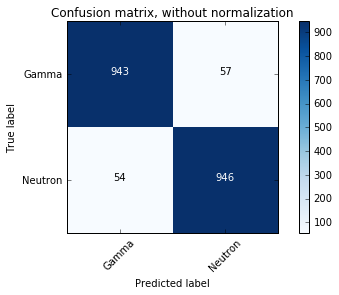

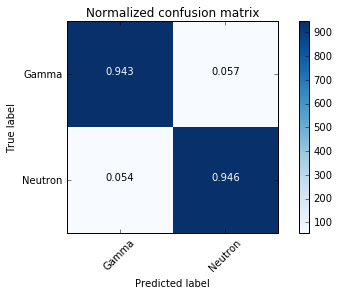

In [38]:
#Lets quantify our (mis)classification of neutrons and gammas using a confusion matrix.
#We'll make gammas 0 and neutrons 1
Neuts_predict = [0 if PSD > PSDcut else 1 for PSD in Qf_neut/Qt_neut]
Gammas_predict = [0 if PSD > PSDcut else 1 for PSD in Qf_gamma/Qt_gamma]
y_pred = np.concatenate((Gammas_predict, Neuts_predict))
y_true = np.concatenate((np.array([0]*len(Gammas_predict)),
                         np.array([1]*len(Neuts_predict))))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Stolen from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt.gcf()

cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)
class_names = ['Gamma', 'Neutron']
print("f1 score: {0}".format(f1_score(y_true, y_pred)))
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Maximum f1 score of 0.6662198391420912 for PSD cut at 0.8217716898867649
f1 score: 0.6662198391420912
Confusion matrix, without normalization
[[ 10 990]
 [  6 994]]
Normalized confusion matrix
[[ 0.01  0.99]
 [ 0.01  0.99]]


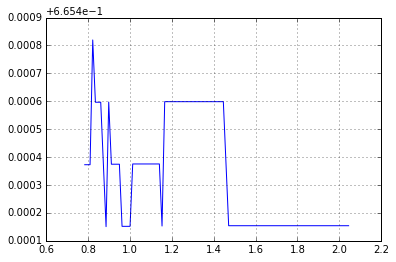

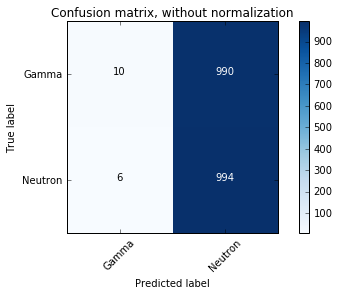

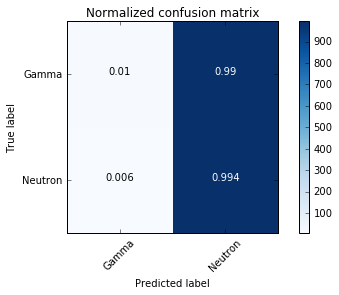

In [30]:
#Let's repeat the above analysis, but step through a bunch of PSD cuts to choose the one which optimises the f1 score:
PSDcut_vector = np.linspace(PSDcut_min, PSDcut_max, 100)
f1scores = np.empty(len(PSDcut_vector), dtype=np.float64)
for i, thisPSDcut in enumerate(PSDcut_vector):
    Neuts_predict = [0 if PSD > thisPSDcut else 1 for PSD in Qf_neut/Qt_neut]
    Gammas_predict = [0 if PSD > thisPSDcut else 1 for PSD in Qf_gamma/Qt_gamma]
    y_pred = np.concatenate((Gammas_predict, Neuts_predict))
    f1scores[i] = f1_score(y_true,y_pred)
print("Maximum f1 score of {0} for PSD cut at {1}".format(max(f1scores), PSDcut_vector[np.argmax(f1scores)]))
plt.figure()
plt.plot(PSDcut_vector, f1scores)
plt.grid()
PSDcut_optim = PSDcut_vector[np.argmax(f1scores)]
#repeat it for the optimal PSD cut:
Neuts_predict = [0 if PSD > PSDcut_optim else 1 for PSD in Qf_neut/Qt_neut]
Gammas_predict = [0 if PSD > PSDcut_optim else 1 for PSD in Qf_gamma/Qt_gamma]
y_pred_optim = np.concatenate((Gammas_predict, Neuts_predict))
cnf_matrix_optim = confusion_matrix(y_true, y_pred_optim)
np.set_printoptions(precision=2)
class_names = ['Gamma', 'Neutron']
print("f1 score: {0}".format(f1_score(y_true, y_pred_optim)))
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_optim, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_optim, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Awesomesauce! That looks just like it should!
Now let's train a linear discriminant using labelled noise (=0), gammas (=1), and neutrons (=2).

/home/lbignell/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


explained variance ratio (first two components): [ 0.68  0.02]


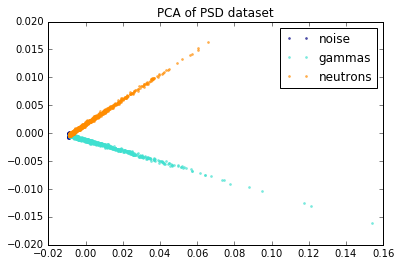

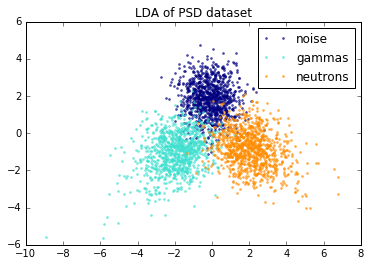

In [16]:
x_noise = np.transpose(Noise)
x_gamma = np.transpose(Gammas)
x_neutron = np.transpose(Neutrons)

y_noise = np.array([0]*Nnoise)
y_gamma = np.transpose([1]*Ngammas)
y_neutron = np.transpose([2]*Nneutrons)

X = np.concatenate((x_noise, x_gamma, x_neutron), axis=0)
y = np.concatenate((y_noise, y_gamma, y_neutron), axis=0)

ncomponents = 2
pca = PCA(n_components=ncomponents)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=ncomponents)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2
types = ['noise', 'gammas', 'neutrons']

for color, i, target_name in zip(colors, [0, 1, 2], types):
    plt.plot(X_r[y == i, 0], X_r[y == i, 1], '.', color=color, alpha=.7, lw=lw,
                label=target_name, markersize=4)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of PSD dataset')

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], types):
    plt.plot(X_r2[y == i, 0], X_r2[y == i, 1], '.', alpha=.7, color=color,
                label=target_name, markersize=4)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of PSD dataset')

plt.show()

Well, that looks pretty good!
To make if a fair comparison with the $Q_{fast}/Q_{total}$ method, let's make a new transform without the noise...

/home/lbignell/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


explained variance ratio (first two components): [  7.39e-01   3.08e-02   3.32e-04   3.26e-04   3.23e-04   3.21e-04
   3.20e-04   3.18e-04   3.17e-04   3.16e-04]
LDA cut: 0.0


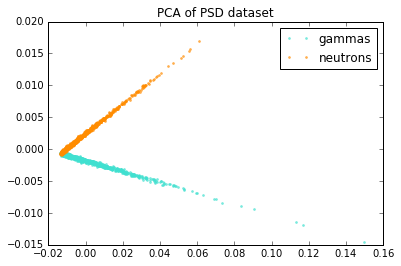

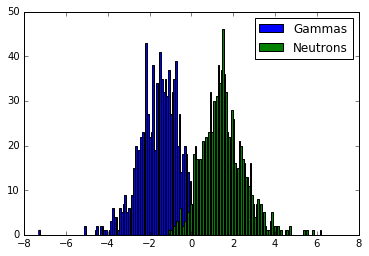

In [17]:
x_gamma = np.transpose(Gammas[1900:,:])
x_neutron = np.transpose(Neutrons[1900:,:])

y_gamma = np.transpose([0]*Ngammas)
y_neutron = np.transpose([1]*Nneutrons)

X = np.concatenate((x_gamma, x_neutron), axis=0)
y = np.concatenate((y_gamma, y_neutron), axis=0)

ncomponents = 10
pca = PCA(n_components=ncomponents)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=ncomponents)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['turquoise', 'darkorange']
lw = 2
types = ['gammas', 'neutrons']

for color, i, target_name in zip(colors, [0, 1], types):
    plt.plot(X_r[y == i, 0], X_r[y == i, 1], '.', color=color, alpha=.7, lw=lw,
                label=target_name, markersize=4)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of PSD dataset')

#plt.figure()
#for color, i, target_name in zip(colors, [0, 1], types):
#    plt.plot(X_r2[y == i, 0], X_r2[y == i, 1], '.', alpha=.7, color=color,
#                label=target_name, markersize=4)
#plt.legend(loc='best', shadow=False, scatterpoints=1)
#plt.title('LDA of PSD dataset')

plt.figure()
plt.hist(X_r2[y==0], bins=100, label='Gammas')
plt.hist(X_r2[y==1], bins=100, label='Neutrons')
plt.legend()

PSDcut_LDA = (np.mean(X_r2[y==0])+np.mean(X_r2[y==1]))/2
print("LDA cut: {0}".format(PSDcut_LDA))

plt.show()

f1 score: 0.9438877755511021
Confusion matrix, without normalization
[[946  54]
 [ 58 942]]
Normalized confusion matrix
[[ 0.95  0.05]
 [ 0.06  0.94]]


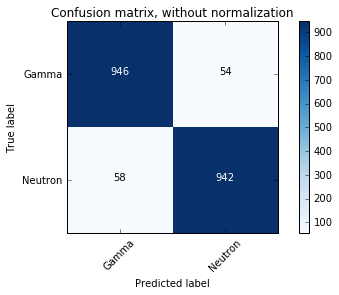

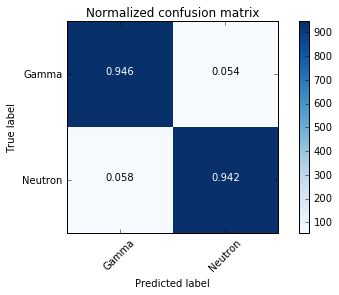

In [18]:
#Lets quantify our (mis)classification of neutrons and gammas using a confusion matrix.
Neuts_predict_LDA = [0 if PSD < PSDcut_LDA else 1 for PSD in X_r2[y==1]]
Gammas_predict_LDA = [0 if PSD < PSDcut_LDA else 1 for PSD in X_r2[y==0]]
y_pred = np.concatenate((Gammas_predict_LDA, Neuts_predict_LDA))
#y_true = np.concatenate((np.array([0]*len(Gammas_predict)),
#                         np.array([1]*len(Neuts_predict))))
cnf_matrix_LDA = confusion_matrix(y, y_pred)
np.set_printoptions(precision=2)
class_names = ['Gamma', 'Neutron']
print("f1 score: {0}".format(f1_score(y, y_pred)))
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_LDA, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_LDA, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Well, that's unexpected! It seems I have misunderstood what LDA does (or at least its implemenentation in sklearn).

What I seem to have done is project the data onto a N-1 dimensional space which maximises that difference between N classes. I don't think this is what I want, since PCA seems to indicate that there are at least 2 dimensions which contribute information (or at least explain the variance in the data).

At least we have made the errors symmetric, which I guess I could do by tuning the PSD cut using the normal approach (it might be interesting to see how that goes). The f1 scores are similar but I think overall it's hard to argue that the LDA is doing any better.

But, since there are only 2 PCA dimensions that contribute information; what happens if we do LDA on those?...

(-1, 1)

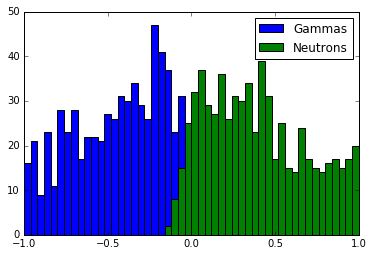

In [19]:
#I wonder what happens if we make a new LDA classifier using the PCA-decomposed data:
X_decomp = X_r[:, :2]
lda_2 = LinearDiscriminantAnalysis(n_components=2)
X_lda2 = lda_2.fit(X_decomp, y).transform(X_decomp)
plt.figure()
plt.hist(X_lda2[y==0], bins=400, range=(-8,8), label='Gammas')
plt.hist(X_lda2[y==1], bins=400, range=(-8,8), label='Neutrons')
plt.legend()
plt.xlim(-1,1)

f1 score: 0.9683995922528033
Confusion matrix, without normalization
[[988  12]
 [ 50 950]]
Normalized confusion matrix
[[ 0.99  0.01]
 [ 0.05  0.95]]


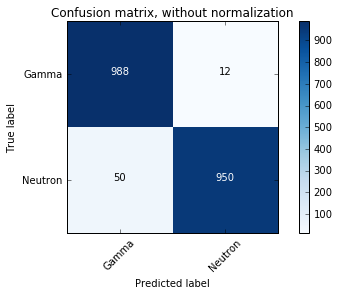

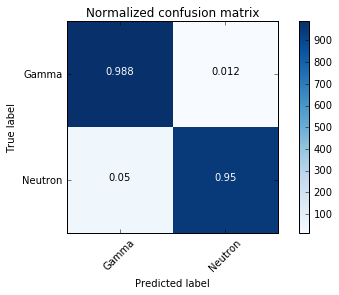

In [20]:
#Lets quantify our (mis)classification of neutrons and gammas using a confusion matrix.
Neuts_predict_LDA2 = [0 if PSD < 0 else 1 for PSD in X_lda2[y==1]]
Gammas_predict_LDA2 = [0 if PSD < 0 else 1 for PSD in X_lda2[y==0]]
y_pred_LDA2 = np.concatenate((Gammas_predict_LDA2, Neuts_predict_LDA2))
#y_true = np.concatenate((np.array([0]*len(Gammas_predict)),
#                         np.array([1]*len(Neuts_predict))))
cnf_matrix_LDA2 = confusion_matrix(y, y_pred_LDA2)
np.set_printoptions(precision=2)
class_names = ['Gamma', 'Neutron']
print("f1 score: {0}".format(f1_score(y, y_pred_LDA2)))
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_LDA2, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_LDA2, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Well, that's certainly better than either of the other attempts.
Yay!

But we can do better... For a DM experiment, what you *really* don't want is to mistake a gamma for a neutron. Mistaking neutrons for gammas is bad, but not nearly as bad. Some future work can look at minimising the number of events in the top right of the confusion matrix, while keeping the number in the bottom left low...

Other things to try:

- Do a similar thing in frequency space (it may make it easier to discriminate noise).

- Clean up noise (frequency filter, or some other way) and then do similar analysis.

- Rather than using LDA for the last step, use some other ML classifier (SVM?). This can take the first N dimensions from the PCA. The 'pipeline' feature in sklearn may be useful here.

- Investigate whether LDA can be implemented better (do we have to reduce it to # classes - 1 or can we leave it as higher dimensional? What about non-linear transforms which are achieveable using a kernel method?)

- Do these results hold for the really small amount of PSD in the SABRE energy range?

- What about optimising the PSD integration lengths? My experience with this tells me that as long as we're integrating a 'long enough' region the FOM won't change by much.

Let's first try to make some data that are a bit more like what SABRE will be measuring. I'll make figure 2 in [this paper](https://arxiv.org/pdf/1503.05253.pdf) what I'll aim for:

Crude FOM: 0.013509108094587293
Half-way cut: 0.2667121339598254


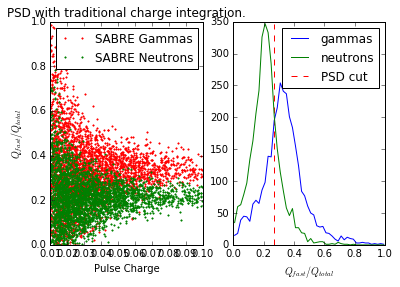

In [25]:
#Set up convolution parameters
#For few photon events the PMT's broadening should have a relatively greater impact.
conv_sigma = 5
conv_mean = 0
convrange = conv_sigma*5
conv_kernel = (1./np.sqrt(2*np.pi*conv_sigma**2))*\
    np.exp(-0.5*(((np.linspace(-convrange,convrange,convrange+1)-conv_mean)/conv_sigma)**2))
conv_mode = 'same'

noise_lvl = 0.0002
scale_factor = 0.05

SABRENgammas = 5000 #12000 x 1000 array ~ 96 MB
SABREGammas = np.random.normal(0, noise_lvl, (12000, SABRENgammas))
for i in range(SABRENgammas):
    thiswfm = get_wfm('gamma', scalefactor=scale_factor)
    if sum(thiswfm)<0:
        print("waveform {0} is wierd: sum = {1}".format(i, sum(thiswfm)))
    SABREGammas[1999:, i] += thiswfm
    SABREGammas[:, i] = np.convolve(SABREGammas[:, i], conv_kernel, mode = conv_mode)
    
SABRENneutrons = 5000 #12000 x 1000 array ~ 96 MB
SABRENeutrons = np.random.normal(0, noise_lvl, (12000, SABRENneutrons))
for i in range(SABRENneutrons):
    thiswfm = get_wfm('neutrons', scalefactor=scale_factor)
    if sum(thiswfm)<0:
        print("waveform {0} is wierd: sum = {1}".format(i, sum(thiswfm)))
    SABRENeutrons[1999:, i] += thiswfm
    SABRENeutrons[:, i] = np.convolve(SABRENeutrons[:, i], conv_kernel, mode = conv_mode)

#Lets define the fast integration region as 190:220, and the total integration region as 190:.
SABREQf_gamma = np.sum(SABREGammas[1900:2200, :], axis=0)
SABREQt_gamma = np.sum(SABREGammas[1900:, :], axis=0)

SABREQf_neut = np.sum(SABRENeutrons[1900:2200, :], axis=0)
SABREQt_neut = np.sum(SABRENeutrons[1900:, :], axis=0)

MaxCharge = 0.1
MinCharge = 0.01

selectedQt_gamma = SABREQt_gamma[(SABREQt_gamma<MaxCharge)&(SABREQt_gamma>MinCharge)]
selectedPSD_gamma = (SABREQf_gamma/SABREQt_gamma)[(SABREQt_gamma<MaxCharge)&(SABREQt_gamma>MinCharge)]
selectedQt_neut = SABREQt_neut[(SABREQt_neut<MaxCharge)&(SABREQt_neut>MinCharge)]
selectedPSD_neut = (SABREQf_neut/SABREQt_neut)[(SABREQt_neut<MaxCharge)&(SABREQt_neut>MinCharge)]

plt.subplot(1,2,1)
plt.plot(selectedQt_gamma, selectedPSD_gamma, 'r.', markersize=3, label='SABRE Gammas')
plt.plot(selectedQt_neut, selectedPSD_neut, 'g.', markersize=3, label='SABRE Neutrons')
plt.ylim(0,1)
plt.xlabel("Pulse Charge")
plt.ylabel("$Q_{fast}/Q_{total}$")
plt.title('PSD with traditional charge integration.')
plt.legend(loc='best')

SABRE_PSDg, binedges = np.histogram(selectedPSD_gamma, bins=50, range=(0,1))
SABREbincentres = binedges[:-1] + (binedges[1]-binedges[0])/2
SABRE_PSDn, binedges = np.histogram(selectedPSD_neut, bins=50, range=(0,1))
plt.subplot(1,2,2)
plt.plot(SABREbincentres, SABRE_PSDg, label='gammas')
plt.plot(SABREbincentres, SABRE_PSDn, label='neutrons')
print("Crude FOM: {0}".format((np.mean(selectedPSD_gamma)- np.mean(selectedPSD_neut))/
                              2.35482*(np.std(selectedPSD_gamma)+ np.std(selectedPSD_neut))))
SABREPSDcut = (np.median(selectedPSD_gamma)+ np.median(selectedPSD_neut))/2
print("Half-way cut: {0}".format(SABREPSDcut))
plt.vlines(SABREPSDcut, ymin=0, ymax=max((max(SABRE_PSDg), max(SABRE_PSDn))), 
           colors='r', linestyles='dashed', label='PSD cut')
plt.legend()
plt.xlabel("$Q_{fast}/Q_{total}$")
plt.savefig('/home/lbignell/Lectures/numericalPSD_QfonQt_smallPulses.png')

Crude FOM: 0.008077281042498677
Half-way cut: 0.26277032864549266
911


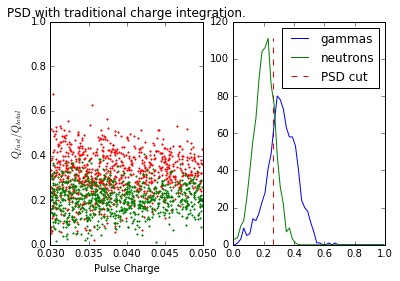

In [31]:
MaxCharge = 0.05
MinCharge = 0.03

selectedQt_gamma = SABREQt_gamma[(SABREQt_gamma<MaxCharge)&(SABREQt_gamma>MinCharge)]
selectedPSD_gamma = (SABREQf_gamma/SABREQt_gamma)[(SABREQt_gamma<MaxCharge)&(SABREQt_gamma>MinCharge)]
selectedQt_neut = SABREQt_neut[(SABREQt_neut<MaxCharge)&(SABREQt_neut>MinCharge)]
selectedPSD_neut = (SABREQf_neut/SABREQt_neut)[(SABREQt_neut<MaxCharge)&(SABREQt_neut>MinCharge)]

plt.subplot(1,2,1)
plt.plot(selectedQt_gamma, selectedPSD_gamma, 'r.', markersize=3, label='SABRE Gammas')
plt.plot(selectedQt_neut, selectedPSD_neut, 'g.', markersize=3, label='SABRE Neutrons')
plt.ylim(0,1)
plt.xlabel("Pulse Charge")
plt.ylabel("$Q_{fast}/Q_{total}$")
plt.title('PSD with traditional charge integration.')

SABRE_PSDg, binedges = np.histogram(selectedPSD_gamma, bins=50, range=(0,1))
SABREbincentres = binedges[:-1] + (binedges[1]-binedges[0])/2
SABRE_PSDn, binedges = np.histogram(selectedPSD_neut, bins=50, range=(0,1))
plt.subplot(1,2,2)
plt.plot(SABREbincentres, SABRE_PSDg, label='gammas')
plt.plot(SABREbincentres, SABRE_PSDn, label='neutrons')
print("Crude FOM: {0}".format((np.mean(selectedPSD_gamma)- np.mean(selectedPSD_neut))/
                              2.35482*(np.std(selectedPSD_gamma)+ np.std(selectedPSD_neut))))
SABREPSDcut = (np.mean(selectedPSD_gamma)+ np.mean(selectedPSD_neut))/2
print("Half-way cut: {0}".format(SABREPSDcut))
plt.vlines(SABREPSDcut, ymin=0, ymax=max((max(SABRE_PSDg), max(SABRE_PSDn))), 
           colors='r', linestyles='dashed', label='PSD cut')
plt.legend()
print(sum(SABRE_PSDn))

That looks close enough to the data from the paper to me (specifically, the 4-5 keV data).

In [32]:
PSD_X = np.concatenate((np.concatenate((selectedQt_gamma[:,None], selectedPSD_gamma[:,None]),axis=1),
                        np.concatenate((selectedQt_neut[:,None], selectedPSD_neut[:,None]),axis=1)), axis=0)
np.shape(PSD_X)

(1778, 2)

False positive neutron rate < 0.2 for PSD cut at 1.280342165431096
f1 score: 0.6795395469736354
Confusion matrix, without normalization
[[  0 863]
 [  0 915]]
Normalized confusion matrix
[[ 0.  1.]
 [ 0.  1.]]


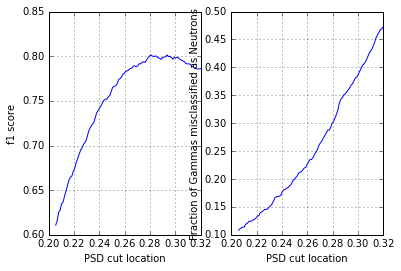

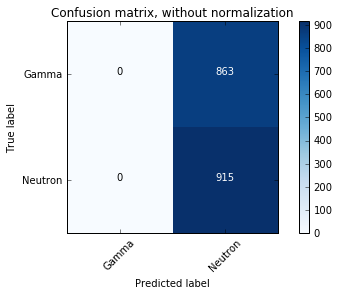

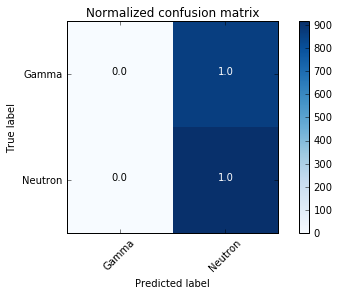



LDA cut:


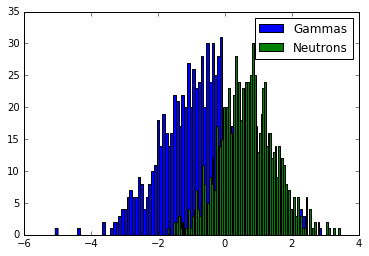

f1 score: 0.7801188546731496
Confusion matrix, without normalization
[[649 214]
 [193 722]]
Normalized confusion matrix
[[ 0.75  0.25]
 [ 0.21  0.79]]


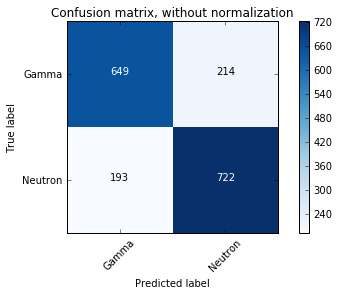

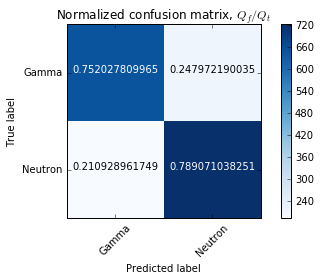

In [41]:
#Let's repeat the above Qfast/Qtotal analysis, but rather than using f1, find the value which makes the probability of
#misclassifying a gamma event as a neutron event < 0.01:
SABRE_PSDcut_min = min((np.mean(selectedPSD_gamma), np.mean(selectedPSD_neut)))
SABRE_PSDcut_max = max((np.mean(selectedPSD_gamma), np.mean(selectedPSD_neut)))

SABRE_y_true = np.concatenate((np.array([0]*len(selectedPSD_gamma)),
                               np.array([1]*len(selectedPSD_neut))))

SABRE_PSDcut_vector = np.linspace(SABRE_PSDcut_min, SABRE_PSDcut_max, 100)
SABRE_f1scores = np.empty(len(SABRE_PSDcut_vector), dtype=np.float64)
SABRE_FalsePositive = np.empty(len(SABRE_PSDcut_vector), dtype = np.float64)

for i, thisPSDcut in enumerate(SABRE_PSDcut_vector):
    SABRE_Neuts_predict = [0 if PSD > thisPSDcut else 1 for PSD in selectedPSD_neut]
    SABRE_Gammas_predict = [0 if PSD > thisPSDcut else 1 for PSD in selectedPSD_gamma]
    SABRE_y_pred = np.concatenate((SABRE_Gammas_predict, SABRE_Neuts_predict))
    SABRE_f1scores[i] = f1_score(SABRE_y_true,SABRE_y_pred)
    CM = confusion_matrix(SABRE_y_true, SABRE_y_pred)
    SABRE_FalsePositive[i] = (CM/(np.sum(CM, axis=1)*1.0))[0,1]

SABRE_PSDcut_optim = min(PSDcut_vector[SABRE_FalsePositive>0.2])
print("False positive neutron rate < 0.2 for PSD cut at {0}".format(SABRE_PSDcut_optim))
plt.subplot(1,2,1)
plt.plot(SABRE_PSDcut_vector, SABRE_f1scores)
plt.grid()
plt.ylabel('f1 score')
plt.xlabel('PSD cut location')

plt.subplot(1,2,2)
plt.plot(SABRE_PSDcut_vector, SABRE_FalsePositive)
plt.grid()
plt.ylabel('Fraction of Gammas misclassified as Neutrons')
plt.xlabel('PSD cut location')

#repeat it for the optimal PSD cut:
SABRE_Neuts_predict = [0 if PSD > SABRE_PSDcut_optim else 1 for PSD in selectedPSD_neut]
SABRE_Gammas_predict = [0 if PSD > SABRE_PSDcut_optim else 1 for PSD in selectedPSD_gamma]
SABRE_y_pred_optim = np.concatenate((SABRE_Gammas_predict, SABRE_Neuts_predict))
SABRE_cnf_matrix_optim = confusion_matrix(SABRE_y_true, SABRE_y_pred_optim)
np.set_printoptions(precision=2)
class_names = ['Gamma', 'Neutron']
print("f1 score: {0}".format(f1_score(SABRE_y_true, SABRE_y_pred_optim)))
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(SABRE_cnf_matrix_optim, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(SABRE_cnf_matrix_optim, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#for completeness let's do LDA on the charge-integration PSD cut:
print("\n\nLDA cut:")
PSD_lda = LinearDiscriminantAnalysis()
PSD_X = np.concatenate((np.concatenate((selectedQt_gamma[:,None], selectedPSD_gamma[:,None]),axis=1),
                        np.concatenate((selectedQt_neut[:,None], selectedPSD_neut[:,None]),axis=1)), axis=0)
PSD_X_r = PSD_lda.fit(PSD_X, SABRE_y_true).transform(PSD_X)
plt.figure()
plt.hist(PSD_X_r[SABRE_y_true==0], bins=100, label='Gammas')
plt.hist(PSD_X_r[SABRE_y_true==1], bins=100, label='Neutrons')
plt.legend()

plt.show()

PSD_Neuts_predict_LDA = [0 if PSD < 0 else 1 for PSD in PSD_X_r[SABRE_y_true==1]]
PSD_Gammas_predict_LDA = [0 if PSD < 0 else 1 for PSD in PSD_X_r[SABRE_y_true==0]]
PSD_y_pred_LDA = np.concatenate((PSD_Gammas_predict_LDA, PSD_Neuts_predict_LDA))
PSD_cnf_matrix_LDA = confusion_matrix(SABRE_y_true, PSD_y_pred_LDA)
np.set_printoptions(precision=2)
class_names = ['Gamma', 'Neutron']
print("f1 score: {0}".format(f1_score(SABRE_y_true, PSD_y_pred_LDA)))
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(PSD_cnf_matrix_LDA, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
fig = plot_confusion_matrix(PSD_cnf_matrix_LDA, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, $Q_{f}/Q_{t}$')

fig.tight_layout()
fig.savefig('/home/lbignell/Lectures/numericalPSD_QfonQt_smallPulsesConfusionMatrix.png', dpi=200)

plt.show()


I tried to set a reachable Neutron False Positive rate of < 20%.
The closest one in my scan can do this (17.1% (*new data 16.8%*) False Positives), but you have to throw away 41.6% (*new data 92.4%*) of the true neutrons in the process (you lose trigger efficiency).

Changing from a simple PSD cut to an LDA cut buys you much improved performance, which is a bit surprising looking at the data. I wonder if I'm over-fitting? I could synthesise new data to check. I also should, in principle, optimise the integration ranges -- however these should be close to optimal since I already know the fast and slow decay times.

Can the PCA/LDA analysis do better?

/home/lbignell/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


explained variance ratio: [ 0.01  0.    0.    0.    0.  ]


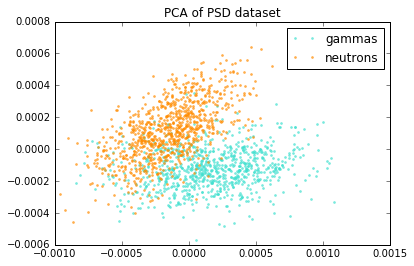

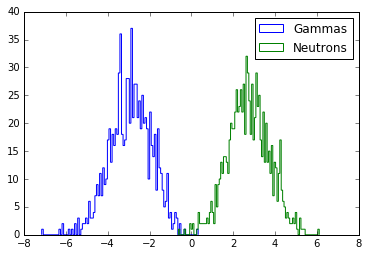

In [46]:
SABRE_x_gamma = np.transpose(SABREGammas[1900:,(SABREQt_gamma<MaxCharge)&(SABREQt_gamma>MinCharge)])
SABRE_x_neutron = np.transpose(SABRENeutrons[1900:,(SABREQt_neut<MaxCharge)&(SABREQt_neut>MinCharge)])

SABRE_y_gamma = np.transpose([0]*len(SABRE_x_gamma))
SABRE_y_neutron = np.transpose([1]*len(SABRE_x_neutron))

SABRE_X = np.concatenate((SABRE_x_gamma, SABRE_x_neutron), axis=0)
SABRE_y = np.concatenate((SABRE_y_gamma, SABRE_y_neutron), axis=0)

ncomponents = 5
SABRE_pca = PCA(n_components=ncomponents)
SABRE_X_r = SABRE_pca.fit(SABRE_X).transform(SABRE_X)

SABRE_lda = LinearDiscriminantAnalysis(n_components=ncomponents)
SABRE_X_r2 = SABRE_lda.fit(SABRE_X, SABRE_y).transform(SABRE_X)

# Percentage of variance explained for each components
print('explained variance ratio: %s'
      % str(SABRE_pca.explained_variance_ratio_))

plt.figure()
colors = ['turquoise', 'darkorange']
lw = 2
types = ['gammas', 'neutrons']

for color, i, target_name in zip(colors, [0, 1], types):
    plt.plot(SABRE_X_r[SABRE_y == i, 0], SABRE_X_r[SABRE_y == i, 1], '.', color=color, alpha=.7, lw=lw,
                label=target_name, markersize=4)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of PSD dataset')

plt.figure()
plt.hist(SABRE_X_r2[SABRE_y==0], bins=100, label='Gammas', histtype='step')
plt.hist(SABRE_X_r2[SABRE_y==1], bins=100, label='Neutrons', histtype='step')
plt.legend()
plt.savefig('/home/lbignell/Lectures/numericalPSD_OverfitPCA_PSD.png', dpi=200)
plt.show()


Whaaat? That LDA plot shouldn't look so good. I really need to look into what's happening under the hood in sklearn. My guess is that we're over-fitting using the noise. It may be worthwhile doing some pre-processing.

The most obvious pre-processing is to use PCA to do dimensional reduction, picking out the 'important' signal components (at least in terms of the variance. So let's try doing LDA on PCA-reduced data (over 5 most important dimensions):

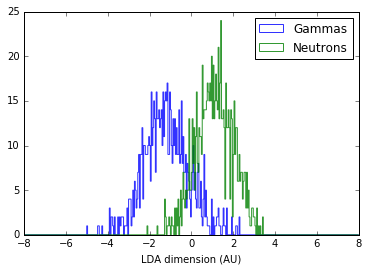

In [43]:
X_decomp = SABRE_X_r
SABRE_lda_2 = LinearDiscriminantAnalysis(n_components=5)
SABRE_X_lda2 = SABRE_lda_2.fit(X_decomp, SABRE_y).transform(X_decomp)
plt.figure()
plt.hist(SABRE_X_lda2[SABRE_y==0], bins=400, range=(-8,8), label='Gammas', alpha=0.8, histtype='step')
plt.hist(SABRE_X_lda2[SABRE_y==1], bins=400, range=(-8,8), label='Neutrons', alpha=0.8, histtype='step')
plt.legend()
#plt.xlim(-1,1)
plt.xlabel('LDA dimension (AU)')
plt.savefig('/home/lbignell/Lectures/numericalPSD_NiceLDA.png', dpi=200)

f1 score: 0.8796992481203006
Confusion matrix, without normalization
[[735 128]
 [ 96 819]]
Normalized confusion matrix
[[ 0.85  0.15]
 [ 0.1   0.9 ]]


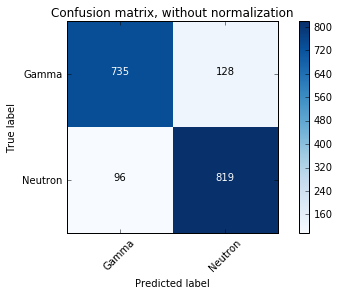

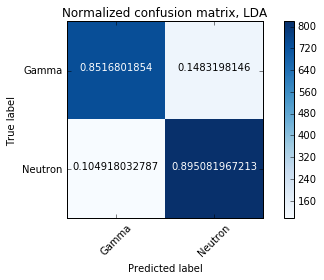

In [44]:
#Lets quantify our (mis)classification of neutrons and gammas using a confusion matrix.
SABRE_Neuts_predict_LDA2 = [0 if PSD < 0 else 1 for PSD in SABRE_X_lda2[SABRE_y==1]]
SABRE_Gammas_predict_LDA2 = [0 if PSD < 0 else 1 for PSD in SABRE_X_lda2[SABRE_y==0]]
SABRE_y_pred_LDA2 = np.concatenate((SABRE_Gammas_predict_LDA2, SABRE_Neuts_predict_LDA2))
#y_true = np.concatenate((np.array([0]*len(Gammas_predict)),
#                         np.array([1]*len(Neuts_predict))))
SABRE_cnf_matrix_LDA2 = confusion_matrix(SABRE_y, SABRE_y_pred_LDA2)
np.set_printoptions(precision=2)
class_names = ['Gamma', 'Neutron']
print("f1 score: {0}".format(f1_score(SABRE_y, SABRE_y_pred_LDA2)))
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(SABRE_cnf_matrix_LDA2, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
fig = plot_confusion_matrix(SABRE_cnf_matrix_LDA2, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, LDA')
fig.tight_layout()
fig.savefig('/home/lbignell/Lectures/numericalPSD_LDA_confusionmatrix.png', dpi=200)
plt.show()

Better for false negatives *and* trigger efficiency. Without optimisation. Boom.

OK, so the obvious criticism here is that I'm comparing apples with crappy apples: although the $Q_{fast}/Q_{total}$ technique is relatively common, it is by no means the best approach for PSD. Let's try some more advanced methods on the same data.

(0, 300)

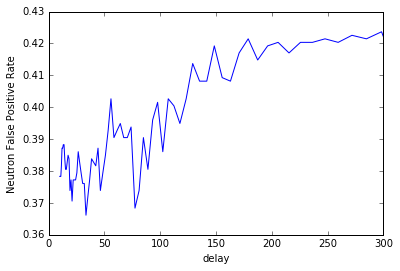

In [36]:
#Pulse Gradient Analysis:
def getPGA(wfms, delay=20):
    """
    Return the max, delayed values of the waveforms for a given delay.
    """
    maxvals = np.max(wfms, axis=1)
    maxidx = np.argmax(wfms, axis=1)
    delayvals = np.array([wfms[i,val + int(delay) if val + int(delay) < np.shape(wfms)[1] else np.shape(wfms)[1]-1] 
             for i, val in enumerate(maxidx)])
    return np.concatenate((maxvals[:,None], delayvals[:,None]), axis=1)
    
delays = np.logspace(1,3,100)
PGA_FalsePositive = np.empty(len(delays), dtype=np.float64)

for i, thisdelay in enumerate(delays):
    PGA_X = getPGA(SABRE_X, delay=thisdelay)
    PGA_lda = LinearDiscriminantAnalysis()
    PGA_X_r = PGA_lda.fit(PGA_X, SABRE_y).transform(PGA_X)
    PGA_y_pred = np.array([0 if PSD < 0 else 1 for PSD in PGA_X_r])
    CM = confusion_matrix(SABRE_y, PGA_y_pred)
    PGA_FalsePositive[i] = (CM/(np.sum(CM, axis=1)*1.0))[0,1]

fig = plt.figure()
plt.plot(delays, PGA_FalsePositive)
plt.xlabel("delay")
plt.ylabel("Neutron False Positive Rate")
plt.xlim(0,300)

f1 score: 0.7417085427135679
Confusion matrix, without normalization
[[564 331]
 [183 738]]
Normalized confusion matrix
[[ 0.63  0.37]
 [ 0.2   0.8 ]]


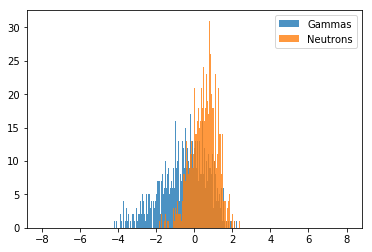

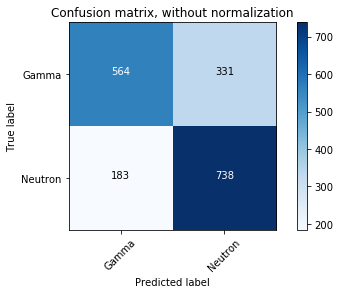

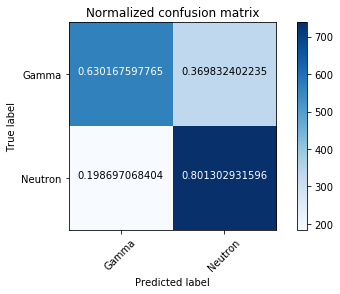

In [100]:
#It looks like we need to choose a delay of ~25, and that they're all pretty rubbish.
#Let's plot the confusion matrix.
PGA_X = getPGA(SABRE_X, delay=25)
PGA_lda = LinearDiscriminantAnalysis()
PGA_X_r = PGA_lda.fit(PGA_X, SABRE_y).transform(PGA_X)
PGA_y_pred = np.array([0 if PSD < 0 else 1 for PSD in PGA_X_r])
PGA_CM = confusion_matrix(SABRE_y, PGA_y_pred)
plt.figure()
plt.hist(PGA_X_r[SABRE_y==0], bins=400, range=(-8,8), label='Gammas', alpha=0.8)
plt.hist(PGA_X_r[SABRE_y==1], bins=400, range=(-8,8), label='Neutrons', alpha=0.8)
plt.legend()
np.set_printoptions(precision=2)
class_names = ['Gamma', 'Neutron']
print("f1 score: {0}".format(f1_score(SABRE_y, PGA_y_pred)))
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(PGA_CM, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(PGA_CM, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


Yep, even worse than $Q_{fast}/Q_{total}$. That's not surprising since we're using very little information from the waveform to make our prediction (only 2/1000 points).

Let's now try what should be a better predictor: the wavelet method [this paper](:

In [37]:
widths = np.arange(1, 31)
CWTenergies = np.empty((np.shape(SABRE_X)[0], 30))
for i,sig in enumerate(SABRE_X):
    cwtmat = signal.cwt(sig, signal.ricker, widths)
    CWTenergy = np.sum(np.power(cwtmat, 2), axis=1)
    CWTenergies[i] = CWTenergy


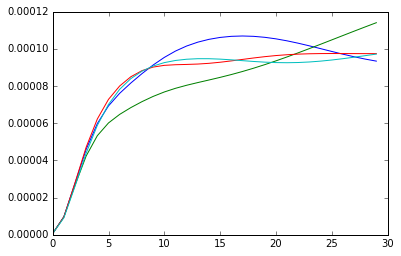

In [38]:
plt.plot(range(30), CWTenergies[10])
plt.plot(range(30), CWTenergies[0])

plt.plot(range(30), CWTenergies[1000])
plt.plot(range(30), CWTenergies[1011])

The CWT seems like a good candidate for LDA, so let's try that:

/home/lbignell/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


f1 score: 0.6536430834213305
Confusion matrix, without normalization
[[568 371]
 [285 619]]
Normalized confusion matrix
[[ 0.6   0.4 ]
 [ 0.32  0.68]]


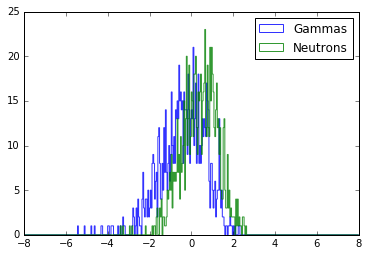

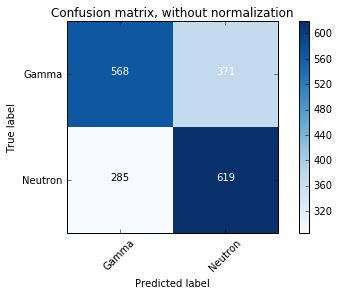

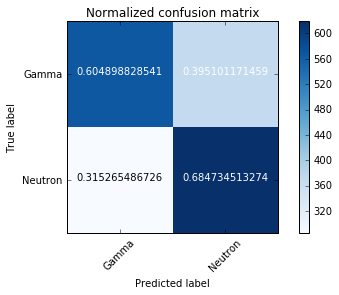

In [40]:
CWT_LDA = LinearDiscriminantAnalysis()
CWT_X_r = CWT_LDA.fit(CWTenergies, SABRE_y).transform(CWTenergies)
CWT_y_pred = np.array([0 if PSD < 0 else 1 for PSD in CWT_X_r])
CWT_CM = confusion_matrix(SABRE_y, CWT_y_pred)
plt.figure()
plt.hist(CWT_X_r[SABRE_y==0], bins=400, range=(-8,8), label='Gammas', alpha=0.8, histtype='step')
plt.hist(CWT_X_r[SABRE_y==1], bins=400, range=(-8,8), label='Neutrons', alpha=0.8, histtype='step')
plt.legend()
np.set_printoptions(precision=2)
class_names = ['Gamma', 'Neutron']
print("f1 score: {0}".format(f1_score(SABRE_y, CWT_y_pred)))
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(CWT_CM, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(CWT_CM, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


That doesn't look right; let's just do something simple, like in the paper.

f1 score: 0.591869918699187
Confusion matrix, without normalization
[[544 395]
 [358 546]]
Normalized confusion matrix
[[ 0.58  0.42]
 [ 0.4   0.6 ]]


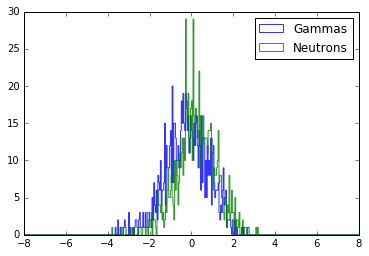

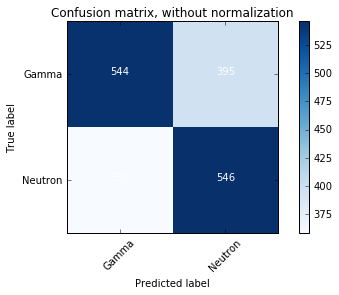

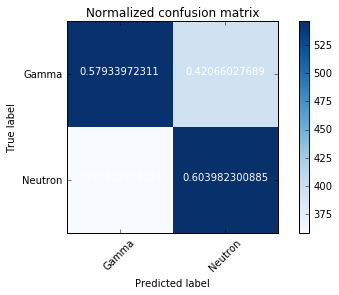

In [42]:
firstidx = 10
secondidx = 25
CWT_X_simple = np.array([np.array([sample[firstidx], sample[secondidx]]) for sample in CWTenergies])
CWT_LDA_simple = LinearDiscriminantAnalysis()
CWT_X_r_simple = CWT_LDA_simple.fit(CWT_X_simple, SABRE_y).transform(CWT_X_simple)
CWT_y_pred_simple = np.array([0 if PSD < 0 else 1 for PSD in CWT_X_r_simple])
CWT_CM_simple = confusion_matrix(SABRE_y, CWT_y_pred_simple)
plt.figure()
plt.hist(CWT_X_r_simple[SABRE_y==0], bins=400, range=(-8,8), label='Gammas', alpha=0.8, histtype='step')
plt.hist(CWT_X_r_simple[SABRE_y==1], bins=400, range=(-8,8), label='Neutrons', alpha=0.8, histtype='step')
plt.legend()
np.set_printoptions(precision=2)
class_names = ['Gamma', 'Neutron']
print("f1 score: {0}".format(f1_score(SABRE_y, CWT_y_pred_simple)))
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(CWT_CM_simple, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(CWT_CM_simple, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


Well that's even worse. Let's try to add PCA in the analysis:

f1 score: 0.6020685900925422
Confusion matrix, without normalization
[[559 380]
 [351 553]]
Normalized confusion matrix
[[ 0.6   0.4 ]
 [ 0.39  0.61]]


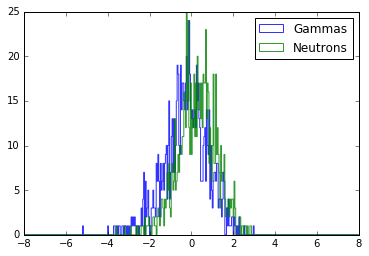

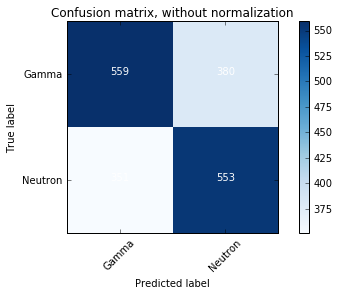

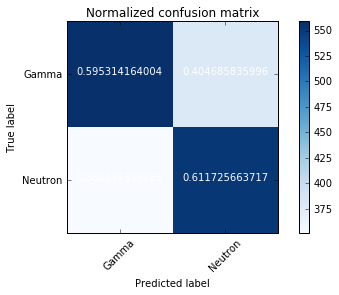

In [43]:
ncomponents = 5
CWT_pca = PCA(n_components=ncomponents)
CWT_X_pca = CWT_pca.fit(CWTenergies).transform(CWTenergies)

CWT_pca_LDA = LinearDiscriminantAnalysis()
CWT_X_pca_LDA = CWT_pca_LDA.fit(CWT_X_pca, SABRE_y).transform(CWT_X_pca)
CWT_pca_LDA_y_pred = np.array([0 if PSD < 0 else 1 for PSD in CWT_X_pca_LDA])
CWT_pca_LDA_CM = confusion_matrix(SABRE_y, CWT_pca_LDA_y_pred)
plt.figure()
plt.hist(CWT_X_pca_LDA[SABRE_y==0], bins=400, range=(-8,8), label='Gammas', alpha=0.8, histtype='step')
plt.hist(CWT_X_pca_LDA[SABRE_y==1], bins=400, range=(-8,8), label='Neutrons', alpha=0.8, histtype='step')
plt.legend()
np.set_printoptions(precision=2)
class_names = ['Gamma', 'Neutron']
print("f1 score: {0}".format(f1_score(SABRE_y, CWT_pca_LDA_y_pred)))
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(CWT_pca_LDA_CM, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(CWT_pca_LDA_CM, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


Well, I don't understand quite why the wavelet approach does so badly. I suppose I should try and replicate the wavelet function that he used in the paper?